In [1]:
import paddle 
import paddle.vision as vision
import numpy as np
import os
import matplotlib.pyplot as plt


net = vision.models.LeNet()
print(type(net))
# print(type(paddle.Model(model)))
# x = paddle.rand([1, 1, 28, 28])
data = np.load('./data/mnist.npz')
print(data['y_train'].shape[0])
print(data['x_train'][0][14])
print(data['y_test'][0:5])
idx = int(input("input idx: "))
x = vision.transforms.to_tensor(data['x_test'][idx])
x = x.reshape((1,1,28,28))
out = net(x)

<class 'paddle.vision.models.lenet.LeNet'>
60000
[  0   0   0   0   0   0   0   0   0   0   0   0   0  81 240 253 253 119
  25   0   0   0   0   0   0   0   0   0]
[7 2 1 0 4]
input idx: 5


In [2]:
parms = net.parameters()
print(parms)

[Parameter containing:
Tensor(shape=[6, 1, 3, 3], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[[[-0.56910574,  0.42018270,  0.11692603],
          [ 0.01887851,  0.00037744,  0.65729594],
          [ 0.23439710, -0.00159273, -0.07650871]]],


        [[[ 0.26149160, -0.30503261, -0.42355189],
          [-0.42304906,  0.62956488, -0.19227313],
          [-0.11380336, -0.26738808,  0.71059823]]],


        [[[-0.40095219, -1.00594938,  0.38675660],
          [ 0.72230005,  0.43479142, -0.42677256],
          [ 0.09753688,  0.28999510, -0.04570077]]],


        [[[-0.00199863,  0.49894321,  0.88587832],
          [ 0.29241908, -0.27011877, -0.56238288],
          [-0.03111903, -0.43227062, -0.27026570]]],


        [[[-0.95176047,  0.13657913,  0.40955734],
          [ 0.63916707,  0.81469119,  0.50533330],
          [ 1.13659441, -0.56049162, -0.01547291]]],


        [[[ 0.03602488,  0.27672753, -0.73770994],
          [-0.14395784,  0.43114755,  0.06261475],
       

C:\MyApps\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
print(paddle.nn.Softmax(out))

Softmax(
  axis=Tensor(shape=[1, 10], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
         [[-0.41690528, -0.09705681, -0.34422994,  2.57324195, -0.21069066, -1.32325518, -0.34774578,  2.05414677,  1.34316111,  1.21175504]])
)


[1, 10]
Tensor(shape=[1, 10], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[-0.41690528, -0.09705681, -0.34422994,  2.57324195, -0.21069066, -1.32325518, -0.34774578,  2.05414677,  1.34316111,  1.21175504]])


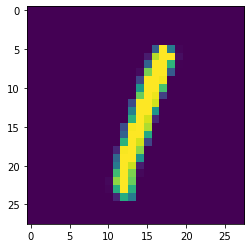

In [4]:
print(out.shape)
print(out)
plt.imshow(np.squeeze(x))
plt.show()

In [5]:
model = paddle.Model(net) # 静态图的话不能缺少input参数
optim = paddle.optimizer.SGD(learning_rate=1e-3,
                            parameters=model.parameters())
model.prepare(optim,
             paddle.nn.CrossEntropyLoss(),
             paddle.metric.Accuracy())
transform = vision.transforms.Compose([
    vision.transforms.Transpose(),
    vision.transforms.Normalize(mean=[127.5, 127.5, 127.5])
])

In [6]:
class DataSet(paddle.io.Dataset):
    def __init__(self, mode='train'):
        super(DataSet, self).__init__()
        self.all_data = np.load('./data/mnist.npz')
        self.mode = mode
        self.train_x = paddle.to_tensor(self.all_data['x_train']/255., dtype='float32').reshape((-1,1,28,28))
        self.test_x = paddle.to_tensor(self.all_data['x_test']/255., dtype='float32').reshape((-1,1,28,28))
        self.train_y = paddle.to_tensor(self.all_data['y_train'], dtype='int64')
        self.test_y = paddle.to_tensor(self.all_data['y_test'], dtype='int64')
        
    def __getitem__(self, idx):
        if self.mode == 'train':
            img = self.train_x[idx]
            label = self.train_y[idx]
            
        else:
            img = self.test_x[idx]
            label = self.train_y[idx]
            
        return img, label
    
    def __len__(self):
        if self.mode == 'train':
            return self.train_y.shape[0]
        else:
            return self.test_y.shape[0]

In [7]:
train_data_gen = paddle.io.DataLoader(DataSet(mode='train'), batch_size=64, shuffle=True, drop_last=True, num_workers=0)
model.fit(train_data_gen, epochs=10, verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10
step  10/937 [..............................] - loss: 2.3256 - acc: 0.1453 - ETA: 14s - 16ms/step

C:\MyApps\Anaconda\lib\site-packages\paddle\fluid\layers\utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 937/937 [==============================] - loss: 0.4621 - acc: 0.7136 - 15ms/step          
Epoch 2/10
step 937/937 [==============================] - loss: 0.2799 - acc: 0.8950 - 14ms/step          
Epoch 3/10
step 937/937 [==============================] - loss: 0.2733 - acc: 0.9160 - 15ms/step          
Epoch 4/10
step 937/937 [==============================] - loss: 0.1425 - acc: 0.9269 - 15ms/step          
Epoch 5/10
step 937/937 [==============================] - loss: 0.1107 - acc: 0.9334 - 15ms/step          
Epoch 6/10
step 937/937 [==============================] - loss: 0.4226 - acc: 0.9396 - 15ms/step          
Epoch 7/10
step 937/937 [==============================] - loss: 0.1767 - acc: 0.9445 - 14ms/step          
Epoch 8/10
step 937/937 [==============================] - loss: 0.1518 - acc: 0.9485 - 15ms/step          
Epoch 9/10
step 937/937 [==============================] - loss: 0.2439 - acc: 0.9524 - 14ms/step          
Epoch 10/10
step 937/937 [=============

In [21]:
test_data_gen = paddle.io.DataLoader(DataSet(mode='test'), batch_size=64, shuffle=True, drop_last=True)
model.evaluate(test_data_gen, verbose=1)

RuntimeError: ResourceExhaustedError: 

Out of memory error on GPU 0. Cannot allocate 179.443604MB memory on GPU 0, 1.924109GB memory has been allocated and available memory is only 77.712111MB.

Please check whether there is any other process using GPU 0.
1. If yes, please stop them, or start PaddlePaddle on another GPU.
2. If no, please decrease the batch size of your model. 

 (at C:\home\workspace\Paddle_release\paddle\fluid\memory\allocation\cuda_allocator.cc:79)
